# Description

- Initialize with returns, predictions, target volatility, and oos start date
- Evaluate portfolios generated from the predictions

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import core.config as cconfig
import core.dataflow_model.model_evaluator as modeval
import core.dataflow_model.model_plotter as modplot
import core.dataflow_model.utils as cdmu
import helpers.dbg as dbg
import helpers.printing as hprint

In [2]:
dbg.init_logger(verbosity=logging.INFO)
# dbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

# _LOG.info("%s", env.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-b1d496a4-89de-4809-8668-94d6dcf97b6b.json'


# Notebook config

In [49]:
# config = cconfig.Config.from_env_var("AM_CONFIG_CODE")
config = None

if config is None:
    # exp_dir = "s3://eglp-spm-sasm/experiments/experiment.RH2Ef.v1_9-all.5T.20210831-004747.run1.tgz"
    # exp_dir = "/app/oos_experiment.RH2Eg.v2_0-top10.5T.run1_test"
    exp_dir = "/app/oos_experiment.RH2Eg.v2_0-top10.5T.run1_test"
    aws_profile = None
    #selected_idxs = None
    selected_idxs = range(1)

    eval_config = cconfig.get_config_from_nested_dict(
        {
            "load_experiment_kwargs": {
                "src_dir": exp_dir,
                "file_name": "result_bundle.v2_0.pkl",
                "experiment_type": "ins_oos",
                "selected_idxs": selected_idxs,
                "aws_profile": aws_profile,
            },
            "model_evaluator_kwargs": {
                "predictions_col": "mid_ret_0_vol_adj_clipped_2_hat",
                "target_col": "mid_ret_0_vol_adj_clipped_2",
                # "oos_start": "2017-01-01",
                "oos_start": None,
            },
            "bh_adj_threshold": 0.1,
            "resample_rule": "W",
            "mode": "ins",
            "target_volatility": 0.1,
        }
    )

print(str(eval_config))

load_experiment_kwargs:
  src_dir: /app/oos_experiment.RH2Eg.v2_0-top10.5T.run1_test
  file_name: result_bundle.v2_0.pkl
  experiment_type: ins_oos
  selected_idxs: range(0, 1)
  aws_profile: None
model_evaluator_kwargs:
  predictions_col: mid_ret_0_vol_adj_clipped_2_hat
  target_col: mid_ret_0_vol_adj_clipped_2
  oos_start: None
bh_adj_threshold: 0.1
resample_rule: W
mode: ins
target_volatility: 0.1


# Initialize ModelEvaluator and ModelPlotter

In [50]:
load_config = eval_config["load_experiment_kwargs"].to_dict()

# Load only the columns needed by the ModelEvaluator.
load_config["load_rb_kwargs"] = {
    "columns": [
        eval_config["model_evaluator_kwargs"]["target_col"],
        eval_config["model_evaluator_kwargs"]["predictions_col"],
    ]
}
result_bundle_dict = cdmu.load_experiment_artifacts(**load_config)

# Build the ModelEvaluator.
evaluator = modeval.ModelEvaluator.from_result_bundle_dict(
    result_bundle_dict,
    # abort_on_error=False,
    abort_on_error=True,
    **eval_config["model_evaluator_kwargs"].to_dict(),
)
# Build the ModelPlotter.
plotter = modplot.ModelPlotter(evaluator)

Before load_experiment_artifacts: memory_usage=rss=1.895GB vms=5.381GB mem_pct=3%
# Load artifacts 'result_bundle.v2_0.pkl' from '/app/oos_experiment.RH2Eg.v2_0-top10.5T.run1_test'
Found 10 experiment subdirs in '/app/oos_experiment.RH2Eg.v2_0-top10.5T.run1_test'


Loading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

load_experiment_artifacts: memory_usage=rss=1.995GB vms=5.405GB mem_pct=3%
After load_experiment_artifacts: memory_usage=rss=1.995GB vms=5.405GB mem_pct=3%
Before building ModelEvaluator: memory_usage=rss=1.995GB vms=5.405GB mem_pct=3%
After building ModelEvaluator: memory_usage=rss=1.995GB vms=5.405GB mem_pct=3%


In [ ]:
result_bundle_dict[0].config

In [ ]:
result_bundle_dict[0].result_df.dropna()

In [12]:
import vendors_lime.taq_bars.utils as vltbut
import datetime

import pandas as pd
import numpy as np

In [6]:
# Load the 1min data.
columns = ['end_time', 'close', 'volume', 'egid', 'good_ask', 'good_bid', 'good_bid_size', 'good_ask_size']
cache_dir = "/cache/vltbut.get_bar_data.v2_1-all.2009_2019.20210907-07_52_53/cache.get_bar_data.v2_0-all.2009_2019"
df_1min = vltbut.load_single_instrument_data(10025, datetime.date(2009, 1, 1), datetime.date(2019, 1, 1), columns=columns, cache_dir=cache_dir)

df_1min.head()

Using function-specific cache in '/cache/vltbut.get_bar_data.v2_1-all.2009_2019.20210907-07_52_53/cache.get_bar_data.v2_0-all.2009_2019'
Setting enable_read_only to False -> True
  --> Cache data for 'get_bar_data' from 'disk' cache (size=225.8 MB, time=0.37 s, tag=None, loc=/cache/vltbut.get_bar_data.v2_1-all.2009_2019.20210907-07_52_53/cache.get_bar_data.v2_0-all.2009_2019)


,close,volume,egid,good_ask,good_bid,good_bid_size,good_ask_size
end_time,,,,,,,
2009-01-02 09:01:00-05:00,NaN,0,10025,8.21,7.17,2500,100
2009-01-02 09:02:00-05:00,NaN,0,10025,8.21,7.17,2500,100
2009-01-02 09:03:00-05:00,NaN,0,10025,8.21,7.17,2500,100
2009-01-02 09:04:00-05:00,NaN,0,10025,8.21,7.17,2500,100
2009-01-02 09:05:00-05:00,NaN,0,10025,8.21,7.17,2500,100


In [111]:
df_1min[["close"]].min()

close    0.1347
dtype: float64

In [151]:
df_1min_out = df_1min[["close", "good_bid", "good_ask"]]

df_1min_out = df_1min_out.resample("1T", closed="right", label="right").mean()
mask = df_1min_out < 0.40
df_1min_out = df_1min_out[~mask]

df_1min_out.fillna(method="ffill", limit=None, inplace=True)
# .sum(min_count=1) #.replace(np.nan, 0)

df_1min_out.columns = ["price", "bid", "ask"]

df_1min_out.dropna().head()

,price,bid,ask
end_time,,,
2009-01-02 09:31:00-05:00,8.11,7.71,8.21
2009-01-02 09:32:00-05:00,8.11,7.74,8.20
2009-01-02 09:33:00-05:00,8.11,7.64,8.20
2009-01-02 09:34:00-05:00,8.21,7.83,8.42
2009-01-02 09:35:00-05:00,8.21,7.84,8.44


<AxesSubplot:>

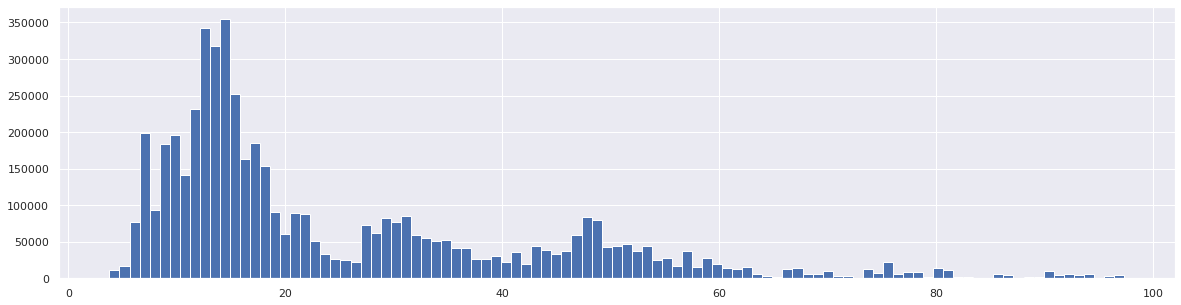

In [152]:
df_1min_out["price"].hist(bins=101)

<AxesSubplot:xlabel='end_time'>

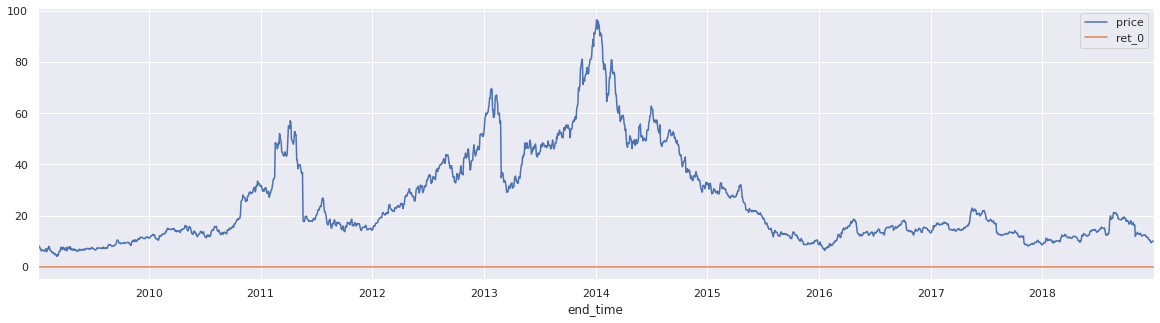

In [140]:
df_price = df_1min_out.resample("5T", closed="right", label="right").last()
df_price["ret_0"] = df_price["price"].pct_change()
df_price.resample("1D").mean().plot()

In [8]:
#import pandas as pd
#df_5mins.loc[pd.Timestamp("2009-01-02 17:00:00-05:00")]

In [34]:
df_1min_out.loc[pd.Timestamp("2009-01-05 13:40:00-05:00"):pd.Timestamp("2009-01-05 14:00:00-05:00")]

,price
end_time,
2009-01-05 13:40:00-05:00,NaN
2009-01-05 13:41:00-05:00,NaN
2009-01-05 13:42:00-05:00,NaN
2009-01-05 13:43:00-05:00,NaN
2009-01-05 13:44:00-05:00,NaN
2009-01-05 13:45:00-05:00,NaN
2009-01-05 13:46:00-05:00,NaN
2009-01-05 13:47:00-05:00,NaN
2009-01-05 13:48:00-05:00,NaN


In [149]:
import core.dataflow_model.pnl_simulator as pnlsim

df_5mins = result_bundle_dict[0].result_df[["mid_ret_0_vol_adj_clipped_2_hat"]]
df_5mins.columns = ["preds"]
df_5mins.dropna(inplace=True)

initial_wealth = 1e6
config = {
    "price_column": "price",
    "future_snoop_allocation": False,
    #"order_type": "price.end",
    #"order_type": "midpoint.end",
    "order_type": "full_spread.end",
    "use_cache": True,
}
df_5mins_out = pnlsim.compute_pnl_level2(df_1min_out, df_5mins, initial_wealth, config)
#wealth, ret, df_5mins_out = pnlsim.compute_pnl_level1(initial_wealth, df_1min_out, df_5mins)

/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


  0%|          | 0/193604 [00:00<?, ?it/s]

/app/amp/core/dataflow_model/pnl_simulator.py:492: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5mins[key] = value + buffer
/app/amp/core/dataflow_model/pnl_simulator.py:579: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5mins["pnl.sim2"] = df_5mins["wealth"].pct_change()


In [99]:
df_5mins_out.tail()

,preds,target_n_shares,cash,holdings,wealth,diff_n_shares,filled_n_shares,cash+1,holdings+1,pnl.sim2
end_time,,,,,,,,,,
2018-12-31 15:40:00-05:00,0.020302,8636.414712,4.281633e+06,3978.688716,4.322056e+06,4657.725996,4657.725996,4.234264e+06,8636.414712,0.000011
2018-12-31 15:45:00-05:00,-0.001626,-691.204693,4.234264e+06,8636.414712,4.322096e+06,-9327.619405,-9327.619405,4.328984e+06,-691.204693,0.000009
2018-12-31 15:50:00-05:00,0.011100,4724.107276,4.328984e+06,-691.204693,4.321965e+06,5415.311969,5415.311969,4.274181e+06,4724.107276,-0.000030
2018-12-31 15:55:00-05:00,-0.008769,-3745.214850,4.274181e+06,4724.107276,4.321989e+06,-8469.322125,-8469.322125,4.360314e+06,-3745.214850,0.000006
2018-12-31 16:00:00-05:00,-0.021817,NaN,NaN,NaN,4.322225e+06,NaN,NaN,NaN,NaN,0.000055


<AxesSubplot:xlabel='end_time'>

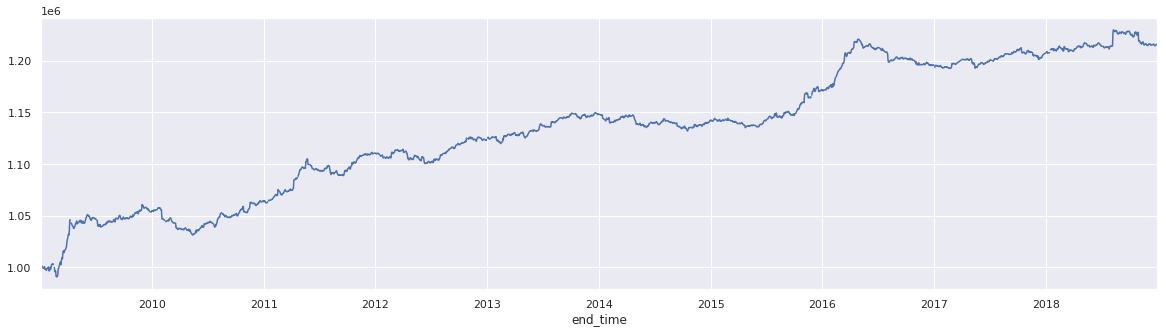

In [150]:
df_5mins_out["wealth"].resample("1B").mean().plot()#["2012-01-01":].plot()

<AxesSubplot:xlabel='end_time'>

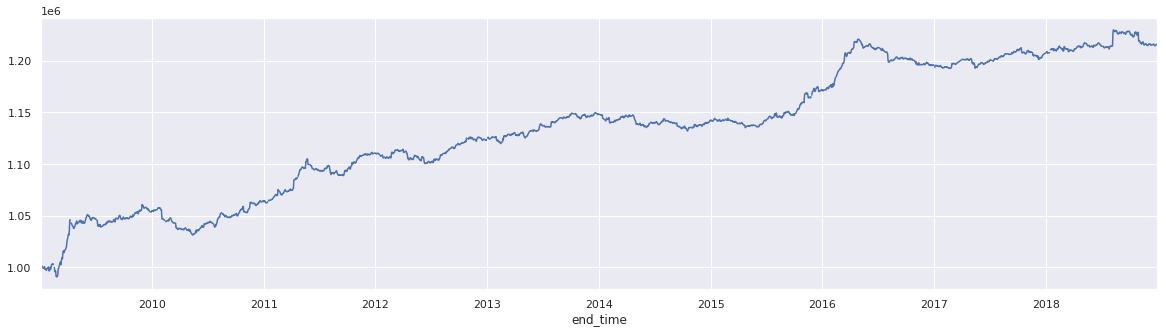

In [146]:
df_5mins_out["wealth"].resample("1B").mean().plot()#["2012-01-01":].plot()

<AxesSubplot:xlabel='end_time'>

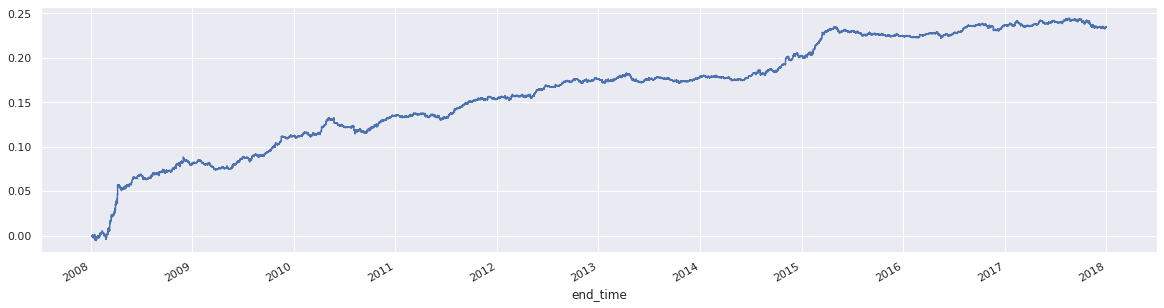

In [95]:
df_5mins_merged = df_5mins_out.merge(df_price, right_index=True, left_index=True)

_, df_5mins_merged = pnlsim.compute_lag_pnl(df_5mins_merged)
#display(df_5mins_merged)
#df_5mins_merged["pnl.lag"].cumsum().plot()
df_5mins_merged["pnl.sim1"].cumsum().plot()

In [17]:
df_5mins_out

,preds,target_n_shares,cash,holdings,wealth,diff_n_shares,filled_n_shares,cash+1,holdings+1,pnl.sim2
end_time,,,,,,,,,,
2009-01-05 13:55:00-05:00,-0.002524,NaN,1000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05 14:00:00-05:00,-0.009451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05 14:05:00-05:00,0.000822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05 14:10:00-05:00,0.006409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05 14:15:00-05:00,0.046417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2009-01-23 13:25:00-05:00,0.020332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-23 13:30:00-05:00,0.008293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-23 13:35:00-05:00,0.005902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

In [51]:
pnl_stats = evaluator.calculate_stats(
    mode=eval_config["mode"], target_volatility=eval_config["target_volatility"]
)
display(pnl_stats)

Calculating positions:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating stats:   0%|          | 0/1 [00:00<?, ?it/s]

0
finance        avg_turnover_(%)                                         114.606074
               turnover_frequency                                    <5 * Minutes>
               avg_holding_period                                         0.872554
               holding_period_units                                  <5 * Minutes>
sampling       start_time                                2009-01-05 13:55:00-05:00
               end_time                                  2018-12-31 15:50:00-05:00
               n_sampling_points                                            188574
               frequency                                             <5 * Minutes>
               sampling_points_per_year                                 105156.125
               time_span_in_years                                         9.988577
               n_rows                                                      1051296
               frac_zero                                                  0.006565
               frac_nan                                                   0.820627
               frac_inf                                                        0.0
               frac_constant                                              0.002275
               num_finite_samples                                           188574
               num_finite_samples_inv                                     0.000005
               num_finite_samples_inv_dyadic_scale                             -18
               num_finite_samples_sqrt                                  434.251079
               num_finite_samples_sqrt_inv                                0.002303
               num_finite_samples_sqrt_inv_dyadic_scale                         -9
               num_unique_values                                            181673
summary        scipy.mean                                                 0.000009
               scipy.std                                                  0.000728
               scipy.skew                                                 0.248904
               scipy.kurtosis                                            20.770358
               null_mean_zero.tval                                        5.470043
               null_mean_zero.pval                                             0.0
               jensen_ratio                                               0.495235
               count                                                      188574.0
               mean                                                       0.000009
               std                                                        0.000728
               min                                                       -0.009777
               25%                                                       -0.000132
               50%                                                             0.0
               75%                                                        0.000142
               max                                                        0.009763
stationarity   adf.stat                                                -214.073187
               adf.pval                                                        0.0
               adf.used_lag                                                    3.0
               adf.nobs                                                   188570.0
               adf.critical_values_1%                                    -3.430385
               adf.critical_values_5%                                    -2.861555
               adf.critical_values_10%                                   -2.566778
               adf.ic_best                                         -2190254.529909
               kpss.stat                                                  0.361139
               kpss.pval                                                  0.093905
               kpss.lags                                                      16.0
              

## Model selection

Calculating positions:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/1 [00:00<?, ?it/s]

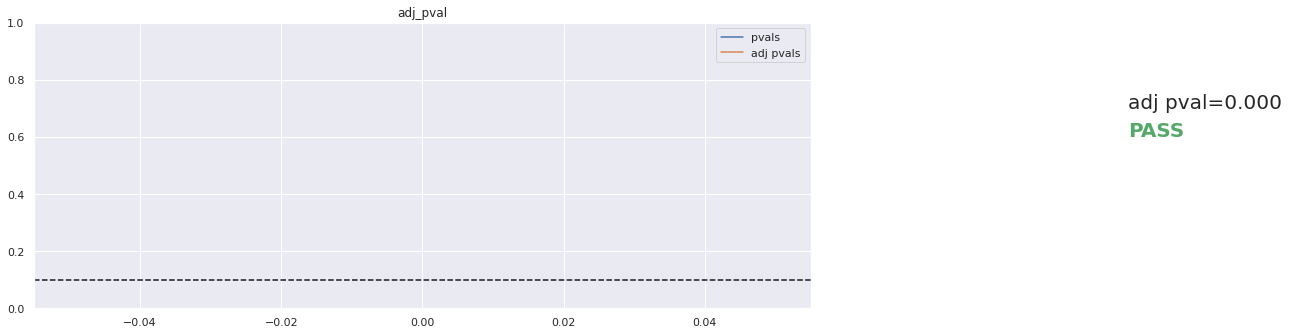

In [52]:
plotter.plot_multiple_tests_adjustment(
    threshold=eval_config["bh_adj_threshold"], mode=eval_config["mode"]
)

In [53]:
# TODO(gp): Move this chunk of code in a function.
col_mask = (
    pnl_stats.loc["signal_quality"].loc["sr.adj_pval"]
    < eval_config["bh_adj_threshold"]
)
selected = pnl_stats.loc[:, col_mask].columns.to_list()
not_selected = pnl_stats.loc[:, ~col_mask].columns.to_list()

print("num model selected=%s" % hprint.perc(len(selected), pnl_stats.shape[1]))
print("model selected=%s" % selected)
print("model not selected=%s" % not_selected)

# Use `selected = None` to show all the models.

num model selected=1 / 1 = 100.00%
model selected=[0]
model not selected=[]


Calculating positions:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating positions:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating PnL:   0%|          | 0/1 [00:00<?, ?it/s]

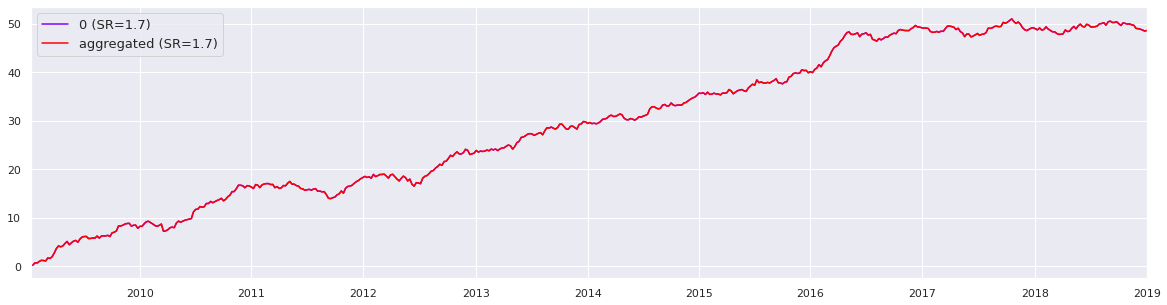

In [54]:
plotter.plot_multiple_pnls(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Return correlation

In [ ]:
plotter.plot_correlation_matrix(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [ ]:
plotter.plot_effective_correlation_rank(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Model correlation

In [ ]:
plotter.plot_correlation_matrix(
    series="pnl",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [ ]:
plotter.plot_effective_correlation_rank(
    series="pnl",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

## Aggregate model

In [ ]:
pnl_srs, pos_srs, aggregate_stats = evaluator.aggregate_models(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)
display(aggregate_stats)

In [ ]:
plotter.plot_sharpe_ratio_panel(keys=selected, mode=eval_config["mode"])

In [ ]:
plotter.plot_rets_signal_analysis(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_performance(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
plotter.plot_rets_and_vol(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
assert 0

In [ ]:
plotter.plot_positions(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

In [ ]:
# Plot the returns and prediction for one or more models.
model_key = selected[:1]
plotter.plot_returns_and_predictions(
    keys=model_key,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)